# The Effect of Tweets on Stock Price Movements
The goal of our project is to find whether tweets by a company's official account affect its stock price. In a separate file, we used the tweet sentiment as the only feature (X) and classified daily stock price movements into class 1 (up) or class 0 (down). However, it ended up with low accuracy scores around 50%. <br>
In this file, starting from the assumption that the most important feature is the previous stock price, we examine whether the tweet sentiment improves the performance of models based on stock prices in the past. In specific, we compare the peformance of a model based on only a moving average of stock prices with that of another model using both the moving average and the tweet sentiment as feature values.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from numpy.random import seed
seed(1)
import calendar
import os
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import hvplot.pandas
import matplotlib.pyplot as plt
from collections import Counter
from panel.interact import interact
import panel as pn
pn.extension('plotly')
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import random
random.set_seed(2)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

from keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(monitor='loss', patience=30)


Bad key "text.kerning_factor" on line 4 in
C:\Users\kn_na\anaconda3\envs\x\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kn_na\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# I. Sentiment Analysis for Tweets

Using Twint, fetch all Tweets by the official accounts of Microsoft, Sony, Pfizer, Regeneron, and Moderna. Then, conduct the sentiment analysis for each Tweet, and calculate the average compound score for each day.

In [2]:
def read_file(ticker):
    # read and cclean up data
    file_path = Path('companies_tweet_data_10y/' + ticker + '.csv')
    tweet_df = pd.read_csv(file_path, 
                           parse_dates=[['date','time']], 
                           infer_datetime_format=True, 
                           usecols=['date',"tweet",'time','retweets_count','likes_count']
                          )
    tweet_df.set_index('date_time', inplace=True)
    tweet_df.index.name = None
    tweet_df.sort_index(axis=0, inplace=True)
    
    # extract tweets before closing time (4 pm)
    tweet_df = tweet_df.between_time('00:00:00','15:59:00', include_end=False)
    tweet_df.index = tweet_df.index.date
    
    # assume the more a tweet is retweeted or liked, the more it would has an impact on stock prices
    # to find some correlation b/w tweets and stock prices more clearly, exclude unimportant tweets
    tweet_df=tweet_df[(tweet_df['retweets_count']>=tweet_df['retweets_count'].mean())\
                      | (tweet_df['likes_count']>=tweet_df['likes_count'].mean())]
    
    return tweet_df

In [3]:
def sentiment_analysis(df):
    tweet_sentiments = []

    for tweet in df["tweet"]:
        try:
            sentiment = analyzer.polarity_scores(tweet)
            compound = sentiment["compound"]
            pos = sentiment["pos"]
            neu = sentiment["neu"]
            neg = sentiment["neg"]
        
            tweet_sentiments.append({"compound": compound,
                                     "positive": pos,
                                     "negative": neg,
                                     "neutral": neu
                                    })
        
        except AttributeError:
            pass
    
    # Create DataFrame
    sentiments_df = pd.DataFrame(tweet_sentiments, index=df.index)
    # Put sentiment scores next to corresponding tweets
    df = df.join(sentiments_df)
    
    # in case of more than one tweet in one day, calculate average compound scores for each day
    sentiment_score_df = df.groupby(level=0)[['compound']].count()
    sentiment_score_df["avg_sentiments"] = df.groupby(level=0)[['compound']].mean()
    sentiment_score_df.drop(columns='compound', inplace=True)
    
    return sentiment_score_df

# II. Calculate Moving Average

In [4]:
def stock_prices():
    load_dotenv()
    
    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

    # Create the Alpaca API object
    api = tradeapi.REST(
        alpaca_api_key,
        alpaca_secret_key,
        api_version = "v2"
    )
    
    #start_date = pd.Timestamp("2009-07-15", tz="America/New_York").isoformat()
    start_date = pd.Timestamp("2015-01-15", tz="America/New_York").isoformat()
    end_date = pd.Timestamp("2021-01-15", tz="America/New_York").isoformat()
    tickers = ["PFE", "MRNA", "REGN", "MSFT", "SNE"]

    # Create the shares DataFrame
    timeframe = "1D"

    stock_tickers = api.get_barset(
        tickers,
        timeframe,
        start = start_date,
        end = end_date
    ).df

    stock_tickerspx = pd.DataFrame()
    stock_tickerspx["PFE"] = stock_tickers["PFE"]["close"]
    stock_tickerspx["MRNA"] = stock_tickers["MRNA"]["close"]
    stock_tickerspx["REGN"] = stock_tickers["REGN"]["close"]
    stock_tickerspx["MSFT"] = stock_tickers["MSFT"]["close"]
    stock_tickerspx["SNE"] = stock_tickers["SNE"]["close"]

    # Drop the time component of the date
    stock_tickerspx.index = stock_tickers.index.date
    index = stock_tickerspx.index
    index.name = "Date"
    stock_tickerspx.reset_index(level=0, inplace=True)
    stock_tickerspx.set_index(pd.to_datetime(stock_tickerspx['Date'], infer_datetime_format=True), 
                              inplace=True, 
                              drop=True
                             )
    stock_tickerspx.drop(columns=['Date'], inplace=True)

    return stock_tickerspx

In [5]:
def manipulate_df(df, ticker):
    signals_df1 = df[[ticker]].copy()
    short_window = 20
    long_window = 100
    signals_df1["SMA20"] = signals_df1[ticker].rolling(window=short_window).mean()
    signals_df1["SMA100"] = signals_df1[ticker].rolling(window=long_window).mean()
    signals_df1["Signal"] = 0.0        
    signals_df1["Signal"][short_window:] = np.where(
        signals_df1["SMA20"][short_window:] > signals_df1["SMA100"][short_window:], 1.0, 0.0
        )   
    signals_df1["Entry/Exit"] = signals_df1["Signal"].diff()
    signals_df1['daily_return']=signals_df1[ticker].pct_change()
    signals_df1['actual_signal'] = np.where(signals_df1['daily_return'] > 0, 1.0, 0.0)
    signals_df1["SMA_shift"]=signals_df1['SMA20'].shift()
    signals_df1.dropna(inplace=True, subset=['daily_return'])
    
    return signals_df1

In [6]:
def final_df(df1, df2, ticker):
    df3=df1.join([df2])
    df3=df3[[ticker,"SMA20","daily_return","actual_signal","avg_sentiments",'SMA_shift']]
    
    return df3

# III. Train/Test Data Creation

## 1. Regression based on 1 Feature

In [7]:
def dataset_regression_1f(df, ticker):
    df = df[['SMA_shift',ticker,'avg_sentiments']]
    df.dropna(inplace=True, subset=['avg_sentiments','SMA_shift',ticker])
    
    X=df[['SMA_shift']].values.reshape(-1,1)
    y=df[[ticker]].values.reshape(-1,1)

    split = int(0.8 * len(X))

    X_train = X[: split]
    X_test = X[split:]

    y_train = y[: split]
    y_test = y[split:]
    
    return X, X_train, X_test, y, y_train, y_test

In [8]:
def scaler_regression_1f(X, X_train, X_test, y, y_train, y_test):
    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the MinMaxScaler object with the features data X
    scaler.fit(X)

    # Scale the features training and testing sets
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit the MinMaxScaler object with the target data Y
    scaler.fit(y)

    # Scale the target training and testing sets
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    
    return X, X_train, X_test, y, y_train, y_test

## 2. Regression based on 2 features

In [9]:
def dataset_regression_2f(df, ticker):
    df = df[['SMA_shift',ticker,'avg_sentiments']]
    df.dropna(inplace=True, subset=['avg_sentiments','SMA_shift',ticker])
    
    X=df[['SMA_shift','avg_sentiments']]
    y=df[[ticker]]

    split = int(0.8 * len(X))

    X_train = X[: split]
    X_test = X[split:]

    y_train = y[: split]
    y_test = y[split:]
    
    return X, X_train, X_test, y, y_train, y_test

In [10]:
def scaler_regression_2f(X, X_train, X_test, y, y_train, y_test):
    scaler = MinMaxScaler()
    
    scaler.fit(X)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    scaler.fit(np.array(y).reshape(-1, 1))

    y_train = scaler.transform(np.array(y_train).reshape(-1, 1))
    y_test = scaler.transform(np.array(y_test).reshape(-1, 1))
    
    return X, X_train, X_test, y, y_train, y_test

## 3. Classification based on 1 feature

In [11]:
def dataset_classification_1f(df, ticker):
    df = df[['SMA_shift',ticker,'avg_sentiments','actual_signal']]
    df.dropna(inplace=True, subset=['avg_sentiments','SMA_shift',ticker])
    
    X=df[['SMA_shift']].values.reshape(-1,1)
    y=df[['actual_signal']].values.reshape(-1,1)

    split = int(0.8 * len(X))

    X_train = X[: split]
    X_test = X[split:]

    y_train = y[: split]
    y_test = y[split:]
    
    return X, X_train, X_test, y, y_train, y_test

In [12]:
def scaler_classification_1f(X, X_train, X_test):
    # y value need not be scaled in classification
    scaler = MinMaxScaler()

    scaler.fit(X)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X, X_train, X_test

## 4. Classification based on 2 Features

In [13]:
def dataset_classification_2f(df, ticker):
    df = df[['SMA_shift',ticker,'avg_sentiments','actual_signal']]
    df.dropna(inplace=True, subset=['avg_sentiments','SMA_shift',ticker])
    
    X=df[['SMA_shift','avg_sentiments']].values.reshape(-1,2)
    y=df[['actual_signal']].values.reshape(-1,1)

    split = int(0.8 * len(X))

    X_train = X[: split]
    X_test = X[split:]

    y_train = y[: split]
    y_test = y[split:]
    
    return X, X_train, X_test, y, y_train, y_test

In [14]:
def scaler_classification_2f(X, X_train, X_test):

    scaler = MinMaxScaler()

    scaler.fit(X)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X, X_train, X_test

# IV. Functions of Models
Abbreviations in the name of functions:<br>
 lr: linear regression<br>
 cl: classification<br>
 1f: 1 feature<br>
 2f: 2 features

## 1. Regression

### (a) Dense based on 1 feature

In [15]:
def dense_lr_1f(X_train, y_train):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(1,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam',
                     loss='mse',
                     metrics=['mae'])
    history = model.fit(X_train, y_train, 
                        batch_size=10, 
                        epochs=200, 
                        verbose=0, 
                        callbacks=[earlystopping]
                       )
    return history, model

In [16]:
def score_dense_lr_1f(history):
    df = pd.DataFrame(history.history, 
                      index=range(1, len(history.history["loss"]) + 1)
                     )
    df=df.rename(columns={'loss': 'loss_1f', 'mae': 'mae_1f'})
    
    return df

In [17]:
def pred_dense_lr_1f(model, X_test, y_test):
    predicted = model.predict(X_test)
    result = pd.DataFrame(predicted)
    result.columns = ['predict_1feature']
    result['actual'] = y_test
    #result.plot()
    return result

### (b) LSTM based on 1 feature

In [18]:
def lstm_lr_1f(X_train, y_train):
    model = Sequential()
    model.add(LSTM(32,
                   return_sequences=True,
                   input_shape=(1,1)
                  )
             )
    model.add(Dropout(0.2))

    #model.add(LSTM(units=4, activation='relu', return_sequences=True))
    model.add(LSTM(units=16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    
    X_train_res=X_train[:,:,np.newaxis]
    
    history=model.fit(X_train_res, y_train, 
                      batch_size=10, 
                      epochs=200, 
                      verbose=0, 
                      callbacks=[earlystopping]
                     )
    
    return history, model

In [19]:
def score_lstm_lr_1f(history):
    df = pd.DataFrame(history.history, 
                      index=range(1, len(history.history["loss"]) + 1)
                     )
    df = df.rename(columns={'loss': 'loss_1f', 'mae': 'mae_1f'})
    
    return df

In [20]:
def pred_lstm_lr_1f(model, X_test, y_test):
    predicted = model.predict(X_test[:,:,np.newaxis])
    result = pd.DataFrame(predicted)
    result.columns = ['predict_1feature']
    result['actual'] = y_test
    
    return result

### (c) Dense based on 2 features

In [21]:
def dense_lr_2f(X_train, y_train):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(2,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    
    history = model.fit(X_train, y_train, 
                        batch_size=10, 
                        epochs=200, 
                        verbose=0, 
                        callbacks=[earlystopping]
                       )
    
    return history, model

In [22]:
def score_dense_lr_2f(history):
    df = pd.DataFrame(history.history, 
                      index=range(1, len(history.history["loss"]) + 1)
                     )
    df=df.rename(columns={'loss': 'loss_2f', 'mae': 'mae_2f'})
    
    return df

In [23]:
def pred_dense_lr_2f(model, X_test, y_test):
    predicted = model.predict(X_test)
    result = pd.DataFrame(predicted)
    result.columns = ['predict_2features']
    result['actual'] = y_test
    
    return result

### (d) LSTM based on 2 features

In [24]:
def lstm_lr_2f(X_train, y_train):
    model = Sequential()
    model.add(LSTM(32,
                   return_sequences=True,
                   input_shape=(2,1)
                  )
             )
    model.add(Dropout(0.2))
    
#     model.add(LSTM(units=4, activation='relu',return_sequences=True))
    model.add(LSTM(units=16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    
    X_train_res=X_train[:,:,np.newaxis]
    
    history=model.fit(X_train_res, y_train, 
                      batch_size=10, 
                      epochs=200, 
                      verbose=0, 
                      callbacks=[earlystopping]
                     )
    
    return history, model

In [25]:
def score_lstm_lr_2f(history):
    df = pd.DataFrame(history.history, 
                      index=range(1, len(history.history["loss"]) + 1)
                     )
    df=df.rename(columns={'loss': 'loss_2f', 'mae': 'mae_2f'})
    
    return df

In [26]:
def pred_lstm_lr_2f(model, X_test, y_test):
    predicted = model.predict(X_test[:,:,np.newaxis])
    result = pd.DataFrame(predicted)
    result.columns = ['predict_2features']
    result['actual'] = y_test

    return result

## 2. Classification

### (a) Dense based on 1 feature

In [27]:
def dense_cl_1f(X_train, y_train):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(1,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
           	      metrics=['acc'])
    
    history=model.fit(X_train, y_train, 
                      batch_size=10, 
                      epochs=200, 
                      verbose=0, 
                      callbacks=[earlystopping]
                     )
    
    return history, model

In [28]:
def eva_dense_cl_1f(model, X_test, y_test):
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    dic = {'Dense': accuracy}
    return dic

### (b) LSTM based on 1 feature

In [29]:
def lstm_cl_1f(X_train, y_train):
    model = Sequential()
    model.add(LSTM(32,
                   return_sequences=True,
                   input_shape=(1,1)
                  )
             )
    model.add(Dropout(0.2))
    
#     model.add(LSTM(units=4, activation='relu', return_sequences=True))
    model.add(LSTM(units=16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    X_train_res = X_train[:,:,np.newaxis]
    
    history = model.fit(X_train_res, y_train, 
                        batch_size=10, 
                        epochs=200, 
                        verbose=0, 
                        callbacks=[earlystopping]
                       )
    
    return history, model

In [30]:
def eva_lstm_cl_1f(model, X_test, y_test):
    accuracy = model.evaluate(X_test[:,:,np.newaxis], y_test, verbose=0)[1]
    dic = {'LSTM': accuracy}
    return dic

### (c) Dense based on 2 features

In [31]:
def dense_cl_2f(X_train, y_train):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(2,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
           	      metrics=['acc'])
    
    history=model.fit(X_train, y_train, 
                      batch_size=10, 
                      epochs=200, 
                      verbose=0, 
                      callbacks=[earlystopping]
                     )
    
    return history, model

In [32]:
def eva_dense_cl_2f(model, X_test, y_test):
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    dic = {'Dense': accuracy}
    return dic

### (d) LSTM based on 2 features

In [33]:
def lstm_cl_2f(X_train, y_train):
    model = Sequential()
    model.add(LSTM(32,
                   return_sequences=True,
                   input_shape=(2,1)
                  )
             )
    model.add(Dropout(0.2))
    
#     model.add(LSTM(units=4,activation='relu', return_sequences=True))
    model.add(LSTM(units=16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['acc'])
    
    X_train_res = X_train[:,:,np.newaxis]
    
    history = model.fit(X_train_res, y_train, 
                        batch_size=10, 
                        epochs=200, 
                        verbose=0, 
                        callbacks=[earlystopping]
                       )
    
    return history, model

In [34]:
def eva_lstm_cl_2f(model, X_test, y_test):
    accuracy = model.evaluate(X_test[:,:,np.newaxis], y_test, verbose=0)[1]
    dic = {'LSTM': accuracy}
    return dic

### (e) Sklearn Models: Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier
It is not obvious which model is most suited for predicting stock price movements, so we examine the 5 models and compare their performances. To finetune performances, we try the cross validation and the grid search.

In [35]:
def sklearn_cl_models(X_train, y_train, X_test, y_test):
    # Logistic regression
    algorithm1 = LogisticRegression(random_state=1)
    # Support vector machine
    algorithm2 = SVC(kernel='rbf', random_state=1)
    # Decision Tree Classifier
    algorithm3 = DecisionTreeClassifier(random_state=1)
    # Random Forest
    algorithm4 = RandomForestClassifier(random_state=1)
    # XGBoost
    algorithm5 = XGBClassifier(random_state=1)
    # Create a list of the five model instances
    algorithms = [algorithm1, algorithm2, algorithm3, algorithm4, algorithm5]
    
    # Create a balanced set of samples, create a StratifiedKFold instance
    stratifiedkfold = StratifiedKFold(n_splits=5)
    
    dic = {}

    
    for algorithm in algorithms:
        algorithm.fit(X_train, y_train)
        score = algorithm.score(X_test, y_test)
        name = algorithm.__class__.__name__
        dic[name] = score 
    
    return dic

In [36]:
def sklearn_cl_models_cross_validation(X, y):
    # Logistic regression
    algorithm1 = LogisticRegression(random_state=1)
    # Support vector machine
    algorithm2 = SVC(kernel='rbf', random_state=1)
    # Decision Tree Classifier
    algorithm3 = DecisionTreeClassifier(random_state=1)
    # Random Forest
    algorithm4 = RandomForestClassifier(random_state=1)
    # XGBoost
    algorithm5 = XGBClassifier(random_state=1)
    # Create a list of the five model instances
    algorithms = [algorithm1, algorithm2, algorithm3, algorithm4, algorithm5]
    
    # Create a balanced set of samples, create a StratifiedKFold instance
    stratifiedkfold = StratifiedKFold(n_splits=5)
    
    dic = {}
    
    for algorithm in algorithms:
        # Conduct cross validation for each one of the five models
        scores = cross_val_score(algorithm, X, y, cv=stratifiedkfold)
        score = scores.mean()
        name = algorithm.__class__.__name__
        dic[name + ' (Cross Validation)'] = score 
    
    return dic

In [37]:
def svc_optimizer(X_train, y_train, X_test, y_test):
    
    params = {'C':[1, 10, 100, 1000, 10000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}
    algorithm = SVC(random_state=1)

    stratifiedkfold = StratifiedKFold(n_splits=5)
    gs = GridSearchCV(algorithm, params, cv=stratifiedkfold)
    gs.fit(X_train, y_train)

    # Based on the best parameters, predict y values from test data
    best = gs.best_estimator_
    best_pred = best.predict(X_test)

    # Accuracy
    score = best.score(X_test, y_test)
    
    dic = {'SVC (Grid Search)': score}
    
    return dic

## 3. Visualization

### (1) Regression

In [38]:
def score_loss_lr_1fvs2f(df_1f, df_2f):
    df=pd.concat([df_1f,df_2f], axis=1)
    return df[['loss_1f','loss_2f']].hvplot()

In [39]:
def score_mae_lr_1fvs2f(df_1f, df_2f):
    df=pd.concat([df_1f,df_2f], axis=1)
    return df[['mae_1f','mae_2f']].hvplot()

In [40]:
def pred_lr_1fvs2f(df_1f, df_2f):
    df=df_1f.merge(df_2f, on='actual')
    return df.hvplot()

### (2) Classification

In [41]:
def score_df(
    dict1, dict2, dict3, dict4, dict5,
    dict6, dict7, dict8, dict9, dict10
):
    dict1.update(dict2)
    dict1.update(dict3)
    dict1.update(dict4)
    dict1.update(dict5)

    dict6.update(dict7)
    dict6.update(dict8)
    dict6.update(dict9)
    dict6.update(dict10)

    df = pd.DataFrame([dict1, dict6], index=['1 Feature', '2 Features'])
    df = df.T
    df["sentiment_impact"] = df['2 Features'] - df['1 Feature']
    
    return df

In [42]:
def plot_data(X, y):
    return plt.scatter(X[:,0],X[:,1],c=y.reshape(1,-1).ravel())

# V. Application to 5 Companies

## 1. MSFT

### (1) Data Creation

In [43]:
df=read_file("MSFT")
df1=sentiment_analysis(df)
df2=stock_prices()
df3=manipulate_df(df2, 'MSFT')
df_MSFT=final_df(df3, df1, 'MSFT')
df_MSFT.head()

,MSFT,SMA20,daily_return,actual_signal,avg_sentiments,SMA_shift
Date,,,,,,
2015-01-16,46.22,NaN,0.016271,1.0,NaN,NaN
2015-01-20,46.39,NaN,0.003678,1.0,0.4767,NaN
2015-01-21,45.91,NaN,-0.010347,0.0,0.0000,NaN
2015-01-22,47.12,NaN,0.026356,1.0,NaN,NaN
2015-01-23,47.18,NaN,0.001273,1.0,NaN,NaN


### (2) Regression

#### (a) Dense 1 feature

In [44]:
X, X_train, X_test, y, y_train, y_test=dataset_regression_1f(df_MSFT, 'MSFT')
X, X_train, X_test, y, y_train, y_test=scaler_regression_1f(X, X_train, X_test, y, y_train, y_test)

In [45]:
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(702, 1)
[[43.582  ]
 [43.501  ]
 [42.94275]
 [43.11525]
 [43.28825]]
(702, 1)
[[43.86 ]
 [43.575]
 [43.87 ]
 [43.27 ]
 [43.09 ]]


In [46]:
msft_dense_lr_1f_history, msft_dense_lr_1f_model =dense_lr_1f(X_train, y_train)

In [47]:
score_dense_lr_1f_df = score_dense_lr_1f(msft_dense_lr_1f_history)

In [48]:
pred_dense_lr_1f_df = pred_dense_lr_1f(msft_dense_lr_1f_model, X_test, y_test)

#### (b) LSTM 1 feature

In [49]:
msft_lstm_lr_1f_history, msft_lstm_lr_1f_model =lstm_lr_1f(X_train, y_train)

In [50]:
score_lstm_lr_1f_df = score_lstm_lr_1f(msft_lstm_lr_1f_history)

In [51]:
pred_lstm_lr_1f_df = pred_lstm_lr_1f(msft_lstm_lr_1f_model, X_test, y_test)

#### (c) Dense 2 features

In [52]:
X, X_train, X_test, y, y_train, y_test=dataset_regression_2f(df_MSFT, 'MSFT')
X, X_train, X_test, y, y_train, y_test=scaler_regression_2f(X, X_train, X_test, y, y_train, y_test)

In [53]:
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(702, 2)
            SMA_shift  avg_sentiments
Date                                 
2015-02-13   43.58200          0.6705
2015-02-17   43.50100          0.4019
2015-03-02   42.94275          0.0000
2015-03-03   43.11525          0.1901
2015-03-05   43.28825          0.0000
(702, 1)
              MSFT
Date              
2015-02-13  43.860
2015-02-17  43.575
2015-03-02  43.870
2015-03-03  43.270
2015-03-05  43.090


In [54]:
msft_dense_lr_2f_history, msft_dense_lr_2f_model = dense_lr_2f(X_train, y_train)

In [55]:
score_dense_lr_2f_df = score_dense_lr_2f(msft_dense_lr_2f_history)

In [56]:
pred_dense_lr_2f_df = pred_dense_lr_2f(msft_dense_lr_2f_model, X_test, y_test)

#### (d) LSTM 2 features

In [57]:
msft_lstm_lr_2f_history, msft_lstm_lr_2f_model = lstm_lr_2f(X_train, y_train)

In [58]:
score_lstm_lr_2f_df = score_lstm_lr_2f(msft_lstm_lr_2f_history)

In [59]:
pred_lstm_lr_2f_df = pred_lstm_lr_2f(msft_lstm_lr_2f_model, X_test, y_test)

#### (e) Visualization
Visualize the results from (a) to (d)

In [60]:
score_loss_lr_1fvs2f(score_dense_lr_1f_df, score_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [61]:
score_mae_lr_1fvs2f(score_dense_lr_1f_df, score_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [62]:
pred_lr_1fvs2f(pred_dense_lr_1f_df, pred_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [63]:
score_loss_lr_1fvs2f(score_lstm_lr_1f_df, score_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [64]:
score_mae_lr_1fvs2f(score_lstm_lr_1f_df, score_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [65]:
pred_lr_1fvs2f(pred_lstm_lr_1f_df, pred_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

### (3) Classification

#### (a) Dense 1 Feature

In [66]:
X, X_train, X_test, y, y_train, y_test = dataset_classification_1f(df_MSFT, "MSFT")
X, X_train, X_test = scaler_classification_1f(X, X_train, X_test)

In [67]:
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(702, 1)
[[43.582  ]
 [43.501  ]
 [42.94275]
 [43.11525]
 [43.28825]]
(702, 1)
[[1.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [68]:
history, model = dense_cl_1f(X_train, y_train)
dic_dense_cl_1f = eva_dense_cl_1f(model, X_test, y_test)

#### (b) LSTM 1 Feature

In [69]:
history, model = lstm_cl_1f(X_train, y_train)
dic_lstm_cl_1f = eva_lstm_cl_1f(model, X_test, y_test)

#### (c) Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [70]:
sklearn_cl_models_1f = sklearn_cl_models(X_train, y_train, X_test, y_test)

[23:25:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [71]:
sklearn_cl_models_cross_validation_1f = sklearn_cl_models_cross_validation(X, y)

[23:25:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:25:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [72]:
svc_optimizer_1f = svc_optimizer(X_train, y_train, X_test, y_test)

#### (d) Dense 2 Features

In [73]:
X, X_train, X_test, y, y_train, y_test = dataset_classification_2f(df_MSFT, "MSFT")
X, X_train, X_test = scaler_classification_2f(X, X_train, X_test)

In [74]:
print(X.shape)
print(X[:5])
print(y.shape)
print(y[:5])

(702, 2)
[[43.582    0.6705 ]
 [43.501    0.4019 ]
 [42.94275  0.     ]
 [43.11525  0.1901 ]
 [43.28825  0.     ]]
(702, 1)
[[1.]
 [0.]
 [1.]
 [0.]
 [1.]]


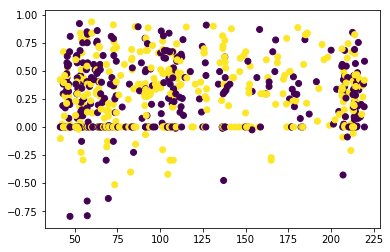

In [75]:
plot_data(X, y)

In [76]:
history, model = dense_cl_2f(X_train, y_train)
dic_dense_cl_2f = eva_dense_cl_2f(model, X_test, y_test)

#### (e) LSTM 2 Features

In [77]:
history, model = lstm_cl_2f(X_train, y_train)
dic_lstm_cl_2f = eva_lstm_cl_2f(model, X_test, y_test)

#### (f) Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [78]:
sklearn_cl_models_2f = sklearn_cl_models(X_train, y_train, X_test, y_test)

[23:26:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [79]:
sklearn_cl_models_cross_validation_2f = sklearn_cl_models_cross_validation(X, y)

[23:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [80]:
svc_optimizer_2f = svc_optimizer(X_train, y_train, X_test, y_test)

### (g) Scores between 1 Feature and 2 Features

In [81]:
score = score_df(dic_dense_cl_1f,
                    dic_lstm_cl_1f,
                    sklearn_cl_models_1f,
                    sklearn_cl_models_cross_validation_1f,
                    svc_optimizer_1f,
                    dic_dense_cl_2f,
                    dic_lstm_cl_2f,
                    sklearn_cl_models_2f,
                    sklearn_cl_models_cross_validation_2f,
                    svc_optimizer_2f
                   )

score

,1 Feature,2 Features,sentiment_impact
DecisionTreeClassifier,0.531915,0.489362,-0.042553
DecisionTreeClassifier (Cross Validation),0.410385,0.403262,-0.007123
Dense,0.531915,0.531915,0.000000
LSTM,0.531915,0.531915,0.000000
LogisticRegression,0.531915,0.531915,0.000000
LogisticRegression (Cross Validation),0.527072,0.535583,0.008511
RandomForestClassifier,0.531915,0.503546,-0.028369
RandomForestClassifier (Cross Validation),0.410385,0.406069,-0.004316
SVC,0.531915,0.531915,0.000000
SVC (Cross Validation),0.504377,0.515724,0.011348


## 2. SNE

### (1) Data Creation

In [82]:
df=read_file("SNE")
df1=sentiment_analysis(df)
df2=stock_prices()
df3=manipulate_df(df2, 'SNE')
df_SNE=final_df(df3, df1, 'SNE')
df_SNE.head()

,SNE,SMA20,daily_return,actual_signal,avg_sentiments,SMA_shift
Date,,,,,,
2015-01-16,20.68,NaN,-0.012416,0.0,NaN,NaN
2015-01-20,20.83,NaN,0.007253,1.0,NaN,NaN
2015-01-21,21.91,NaN,0.051848,1.0,NaN,NaN
2015-01-22,22.17,NaN,0.011867,1.0,NaN,NaN
2015-01-23,22.61,NaN,0.019847,1.0,0.4404,NaN


### (2) Regression

#### (a) Dense 1 feature

In [83]:
X, X_train, X_test, y, y_train, y_test=dataset_regression_1f(df_SNE, 'SNE')
X, X_train, X_test, y, y_train, y_test=scaler_regression_1f(X, X_train, X_test, y, y_train, y_test)

In [84]:
sne_dense_lr_1f_history, sne_dense_lr_1f_model = dense_lr_1f(X_train, y_train)

In [85]:
score_dense_lr_1f_df = score_dense_lr_1f(sne_dense_lr_1f_history)

In [86]:
pred_dense_lr_1f_df = pred_dense_lr_1f(sne_dense_lr_1f_model, X_test, y_test)

#### (b) LSTM 1 feature

In [87]:
sne_lstm_lr_1f_history, sne_lstm_lr_1f_model = lstm_lr_1f(X_train, y_train)

In [88]:
score_lstm_lr_1f_df = score_lstm_lr_1f(sne_lstm_lr_1f_history)

In [89]:
pred_lstm_lr_1f_df = pred_lstm_lr_1f(sne_lstm_lr_1f_model, X_test, y_test)

#### (c) Dense 2 features

In [90]:
X, X_train, X_test, y, y_train, y_test = dataset_regression_2f(df_SNE, 'SNE')
X, X_train, X_test, y, y_train, y_test = scaler_regression_2f(X, X_train, X_test, y, y_train, y_test)

In [91]:
sne_dense_lr_2f_history, sne_dense_lr_2f_model = dense_lr_2f(X_train, y_train)

In [92]:
score_dense_lr_2f_df = score_dense_lr_2f(sne_dense_lr_2f_history)

In [93]:
pred_dense_lr_2f_df = pred_dense_lr_2f(sne_dense_lr_2f_model, X_test, y_test)

#### (d) LSTM 2 features

In [94]:
sne_lstm_lr_2f_history, sne_lstm_lr_2f_model = lstm_lr_2f(X_train, y_train)

In [95]:
score_lstm_lr_2f_df = score_lstm_lr_2f(sne_lstm_lr_2f_history)

In [96]:
pred_lstm_lr_2f_df = pred_lstm_lr_2f(sne_lstm_lr_2f_model, X_test, y_test)

#### (e) Visualization

In [97]:
score_loss_lr_1fvs2f(score_dense_lr_1f_df, score_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [98]:
score_mae_lr_1fvs2f(score_dense_lr_1f_df, score_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [99]:
pred_lr_1fvs2f(pred_dense_lr_1f_df, pred_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [100]:
score_loss_lr_1fvs2f(score_lstm_lr_1f_df, score_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [101]:
score_mae_lr_1fvs2f(score_lstm_lr_1f_df, score_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [102]:
pred_lr_1fvs2f(pred_lstm_lr_1f_df, pred_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

### (3) Classification

#### (a) Dense 1 Feature

In [103]:
X, X_train, X_test, y, y_train, y_test = dataset_classification_1f(df_SNE, "SNE")
X, X_train, X_test = scaler_classification_1f(X, X_train, X_test)

In [104]:
history, model = dense_cl_1f(X_train, y_train)
dic_dense_cl_1f = eva_dense_cl_1f(model, X_test, y_test)

#### (b) LSTM 1 Feature

In [105]:
history, model = lstm_cl_1f(X_train, y_train)
dic_lstm_cl_1f = eva_lstm_cl_1f(model, X_test, y_test)

#### (c) Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [106]:
sklearn_cl_models_1f = sklearn_cl_models(X_train, y_train, X_test, y_test)

[23:26:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [107]:
sklearn_cl_models_cross_validation_1f = sklearn_cl_models_cross_validation(X, y)

[23:26:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [108]:
svc_optimizer_1f = svc_optimizer(X_train, y_train, X_test, y_test)

#### (d) Dense 2 Features

In [109]:
X, X_train, X_test, y, y_train, y_test = dataset_classification_2f(df_SNE, "SNE")
X, X_train, X_test = scaler_classification_2f(X, X_train, X_test)

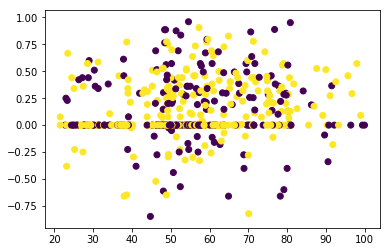

In [110]:
plot_data(X, y)

In [111]:
history, model = dense_cl_2f(X_train, y_train)
dic_dense_cl_2f = eva_dense_cl_2f(model, X_test, y_test)

#### (e) LSTM 2 Features

In [112]:
history, model = lstm_cl_2f(X_train, y_train)
dic_lstm_cl_2f = eva_lstm_cl_2f(model, X_test, y_test)

#### (f) Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [113]:
sklearn_cl_models_2f = sklearn_cl_models(X_train, y_train, X_test, y_test)

[23:27:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [114]:
sklearn_cl_models_cross_validation_2f = sklearn_cl_models_cross_validation(X, y)

[23:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [115]:
svc_optimizer_2f = svc_optimizer(X_train, y_train, X_test, y_test)

### (g) Scores between 1 Feature and 2 Features

In [116]:
score = score_df(dic_dense_cl_1f,
                 dic_lstm_cl_1f,
                 sklearn_cl_models_1f,
                 sklearn_cl_models_cross_validation_1f,
                 svc_optimizer_1f,
                 dic_dense_cl_2f,
                 dic_lstm_cl_2f,
                 sklearn_cl_models_2f,
                 sklearn_cl_models_cross_validation_2f,
                 svc_optimizer_2f
                )

score

,1 Feature,2 Features,sentiment_impact
DecisionTreeClassifier,0.467890,0.568807,0.100917
DecisionTreeClassifier (Cross Validation),0.449541,0.502752,0.053211
Dense,0.596330,0.596330,0.000000
LSTM,0.596330,0.596330,0.000000
LogisticRegression,0.596330,0.587156,-0.009174
LogisticRegression (Cross Validation),0.561468,0.561468,0.000000
RandomForestClassifier,0.467890,0.532110,0.064220
RandomForestClassifier (Cross Validation),0.449541,0.519266,0.069725
SVC,0.605505,0.623853,0.018349
SVC (Cross Validation),0.561468,0.561468,0.000000


## 3. PFE

### (1) Data Creation

In [117]:
df=read_file("PFE")
df1=sentiment_analysis(df)
df2=stock_prices()
df3=manipulate_df(df2, 'PFE')
df_PFE=final_df(df3, df1, 'PFE')
df_PFE.head()

,PFE,SMA20,daily_return,actual_signal,avg_sentiments,SMA_shift
Date,,,,,,
2015-01-16,32.78,NaN,0.011728,1.0,NaN,NaN
2015-01-20,33.10,NaN,0.009762,1.0,0.63690,NaN
2015-01-21,32.66,NaN,-0.013293,0.0,0.38585,NaN
2015-01-22,32.80,NaN,0.004287,1.0,NaN,NaN
2015-01-23,32.45,NaN,-0.010671,0.0,NaN,NaN


### (2) Regression

#### (a) Dense 1 feature

In [118]:
X, X_train, X_test, y, y_train, y_test=dataset_regression_1f(df_PFE, 'PFE')
X, X_train, X_test, y, y_train, y_test=scaler_regression_1f(X, X_train, X_test, y, y_train, y_test)

In [119]:
pfe_dense_lr_1f_history, pfe_dense_lr_1f_model =dense_lr_1f(X_train, y_train)

In [120]:
score_dense_lr_1f_df = score_dense_lr_1f(pfe_dense_lr_1f_history)

In [121]:
pred_dense_lr_1f_df = pred_dense_lr_1f(pfe_dense_lr_1f_model, X_test, y_test)

#### (b) LSTM 1 feature

In [122]:
pfe_lstm_lr_1f_history, pfe_lstm_lr_1f_model =lstm_lr_1f(X_train, y_train)

In [123]:
score_lstm_lr_1f_df = score_lstm_lr_1f(pfe_lstm_lr_1f_history)

In [124]:
pred_lstm_lr_1f_df = pred_lstm_lr_1f(pfe_lstm_lr_1f_model, X_test, y_test)

#### (c) Dense 2 features

In [125]:
X, X_train, X_test, y, y_train, y_test=dataset_regression_2f(df_PFE, 'PFE')
X, X_train, X_test, y, y_train, y_test=scaler_regression_2f(X, X_train, X_test, y, y_train, y_test)

In [126]:
pfe_dense_lr_2f_history, pfe_dense_lr_2f_model = dense_lr_2f(X_train, y_train)

In [127]:
score_dense_lr_2f_df = score_dense_lr_2f(pfe_dense_lr_2f_history)

In [128]:
pred_dense_lr_2f_df = pred_dense_lr_2f(pfe_dense_lr_2f_model, X_test, y_test)

#### (d) LSTM 2 features

In [129]:
pfe_lstm_lr_2f_history, pfe_lstm_lr_2f_model = lstm_lr_2f(X_train, y_train)

In [130]:
score_lstm_lr_2f_df = score_lstm_lr_2f(pfe_lstm_lr_2f_history)

In [131]:
pred_lstm_lr_2f_df = pred_lstm_lr_2f(pfe_lstm_lr_2f_model, X_test, y_test)

#### (e) Visualization

In [132]:
score_loss_lr_1fvs2f(score_dense_lr_1f_df, score_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [133]:
score_mae_lr_1fvs2f(score_dense_lr_1f_df, score_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [134]:
pred_lr_1fvs2f(pred_dense_lr_1f_df, pred_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [135]:
score_loss_lr_1fvs2f(score_lstm_lr_1f_df, score_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [136]:
score_mae_lr_1fvs2f(score_lstm_lr_1f_df, score_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [137]:
pred_lr_1fvs2f(pred_lstm_lr_1f_df, pred_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

### (3) Classification

#### (a) Dense 1 Feature

In [138]:
X, X_train, X_test, y, y_train, y_test = dataset_classification_1f(df_PFE, "PFE")
X, X_train, X_test = scaler_classification_1f(X, X_train, X_test)

In [139]:
history, model = dense_cl_1f(X_train, y_train)
dic_dense_cl_1f = eva_dense_cl_1f(model, X_test, y_test)

#### (b) LSTM 1 Feature

In [140]:
history, model = lstm_cl_1f(X_train, y_train)
dic_lstm_cl_1f = eva_lstm_cl_1f(model, X_test, y_test)

#### (c) Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [141]:
sklearn_cl_models_1f = sklearn_cl_models(X_train, y_train, X_test, y_test)

[23:27:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [142]:
sklearn_cl_models_cross_validation_1f = sklearn_cl_models_cross_validation(X, y)

[23:27:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:27:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [143]:
svc_optimizer_1f = svc_optimizer(X_train, y_train, X_test, y_test)

#### (d) Dense 2 Features

In [144]:
X, X_train, X_test, y, y_train, y_test = dataset_classification_2f(df_PFE, "PFE")
X, X_train, X_test = scaler_classification_2f(X, X_train, X_test)

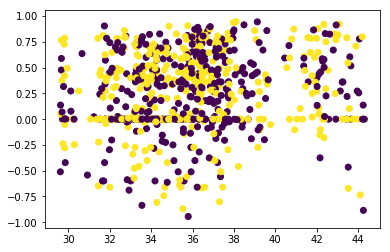

In [145]:
plot_data(X, y)

In [146]:
history, model = dense_cl_2f(X_train, y_train)
dic_dense_cl_2f = eva_dense_cl_2f(model, X_test, y_test)

#### (e) LSTM 2 Features

In [147]:
history, model = lstm_cl_2f(X_train, y_train)
dic_lstm_cl_2f = eva_lstm_cl_2f(model, X_test, y_test)

#### (f) Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [148]:
sklearn_cl_models_2f = sklearn_cl_models(X_train, y_train, X_test, y_test)

[23:28:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [149]:
sklearn_cl_models_cross_validation_2f = sklearn_cl_models_cross_validation(X, y)

[23:28:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [150]:
svc_optimizer_2f = svc_optimizer(X_train, y_train, X_test, y_test)

### (g) Scores between 1 Feature and 2 Features

In [151]:
score = score_df(dic_dense_cl_1f,
                 dic_lstm_cl_1f,
                 sklearn_cl_models_1f,
                 sklearn_cl_models_cross_validation_1f,
                 svc_optimizer_1f,
                 dic_dense_cl_2f,
                 dic_lstm_cl_2f,
                 sklearn_cl_models_2f,
                 sklearn_cl_models_cross_validation_2f,
                 svc_optimizer_2f
                )

score

,1 Feature,2 Features,sentiment_impact
DecisionTreeClassifier,0.500000,0.527027,0.027027
DecisionTreeClassifier (Cross Validation),0.485172,0.500101,0.014929
Dense,0.385135,0.391892,0.006757
LSTM,0.412162,0.425676,0.013514
LogisticRegression,0.385135,0.412162,0.027027
LogisticRegression (Cross Validation),0.487764,0.483719,-0.004045
RandomForestClassifier,0.500000,0.506757,0.006757
RandomForestClassifier (Cross Validation),0.485172,0.493326,0.008154
SVC,0.567568,0.554054,-0.013514
SVC (Cross Validation),0.476990,0.509487,0.032497


## 4. REGN

### (1) Data Creation

In [152]:
df=read_file("REGN")
df1=sentiment_analysis(df)
df2=stock_prices()
df3=manipulate_df(df2, 'REGN')
df_REGN=final_df(df3, df1, 'REGN')
df_REGN.head()

,REGN,SMA20,daily_return,actual_signal,avg_sentiments,SMA_shift
Date,,,,,,
2015-01-16,408.28,NaN,0.028076,1.0,NaN,NaN
2015-01-20,421.11,NaN,0.031425,1.0,NaN,NaN
2015-01-21,418.11,NaN,-0.007124,0.0,NaN,NaN
2015-01-22,420.82,NaN,0.006482,1.0,0.34,NaN
2015-01-23,420.30,NaN,-0.001236,0.0,NaN,NaN


### (2) Regression

#### (a) Dense 1 feature

In [153]:
X, X_train, X_test, y, y_train, y_test = dataset_regression_1f(df_REGN, 'REGN')
X, X_train, X_test, y, y_train, y_test = scaler_regression_1f(X, X_train, X_test, y, y_train, y_test)

In [154]:
regn_dense_lr_1f_history, regn_dense_lr_1f_model = dense_lr_1f(X_train, y_train)

In [155]:
score_dense_lr_1f_df = score_dense_lr_1f(regn_dense_lr_1f_history)

In [156]:
pred_dense_lr_1f_df = pred_dense_lr_1f(regn_dense_lr_1f_model, X_test, y_test)

#### (b) LSTM 1 feature

In [157]:
regn_lstm_lr_1f_history, regn_lstm_lr_1f_model = lstm_lr_1f(X_train, y_train)

In [158]:
score_lstm_lr_1f_df = score_lstm_lr_1f(regn_lstm_lr_1f_history)

In [159]:
pred_lstm_lr_1f_df = pred_lstm_lr_1f(regn_lstm_lr_1f_model, X_test, y_test)

#### (c) Dense 2 features

In [160]:
X, X_train, X_test, y, y_train, y_test = dataset_regression_2f(df_REGN, 'REGN')
X, X_train, X_test, y, y_train, y_test = scaler_regression_2f(X, X_train, X_test, y, y_train, y_test)

In [161]:
regn_dense_lr_2f_history, regn_dense_lr_2f_model = dense_lr_2f(X_train, y_train)

In [162]:
score_dense_lr_2f_df = score_dense_lr_2f(regn_dense_lr_2f_history)

In [163]:
pred_dense_lr_2f_df = pred_dense_lr_2f(regn_dense_lr_2f_model, X_test, y_test)

#### (d) LSTM 2 features

In [164]:
regn_lstm_lr_2f_history, regn_lstm_lr_2f_model = lstm_lr_2f(X_train, y_train)

In [165]:
score_lstm_lr_2f_df = score_lstm_lr_2f(regn_lstm_lr_2f_history)

In [166]:
pred_lstm_lr_2f_df = pred_lstm_lr_2f(regn_lstm_lr_2f_model, X_test, y_test)

#### (e) Visualization

In [167]:
score_loss_lr_1fvs2f(score_dense_lr_1f_df, score_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [168]:
score_mae_lr_1fvs2f(score_dense_lr_1f_df, score_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [169]:
pred_lr_1fvs2f(pred_dense_lr_1f_df, pred_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [170]:
score_loss_lr_1fvs2f(score_lstm_lr_1f_df, score_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [171]:
score_mae_lr_1fvs2f(score_lstm_lr_1f_df, score_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [172]:
pred_lr_1fvs2f(pred_lstm_lr_1f_df, pred_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

### (3) Classification

#### (a) Dense 1 Feature

In [173]:
X, X_train, X_test, y, y_train, y_test = dataset_classification_1f(df_REGN, "REGN")
X, X_train, X_test = scaler_classification_1f(X, X_train, X_test)

In [174]:
history, model = dense_cl_1f(X_train, y_train)
dic_dense_cl_1f = eva_dense_cl_1f(model, X_test, y_test)

#### (b) LSTM 1 Feature

In [175]:
history, model = lstm_cl_1f(X_train, y_train)
dic_lstm_cl_1f = eva_lstm_cl_1f(model, X_test, y_test)

#### (c) Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [176]:
sklearn_cl_models_1f = sklearn_cl_models(X_train, y_train, X_test, y_test)

[23:28:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [177]:
sklearn_cl_models_cross_validation_1f = sklearn_cl_models_cross_validation(X, y)

[23:28:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:28:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [178]:
svc_optimizer_1f = svc_optimizer(X_train, y_train, X_test, y_test)

#### (d) Dense 2 Features

In [179]:
X, X_train, X_test, y, y_train, y_test = dataset_classification_2f(df_REGN, "REGN")
X, X_train, X_test = scaler_classification_2f(X, X_train, X_test)

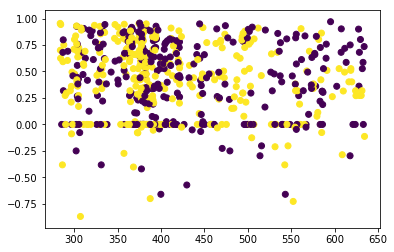

In [180]:
plot_data(X, y)

In [181]:
history, model = dense_cl_2f(X_train, y_train)
dic_dense_cl_2f = eva_dense_cl_2f(model, X_test, y_test)

#### (e) LSTM 2 Features

In [182]:
history, model = lstm_cl_2f(X_train, y_train)
dic_lstm_cl_2f = eva_lstm_cl_2f(model, X_test, y_test)

#### (f) Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [183]:
sklearn_cl_models_2f = sklearn_cl_models(X_train, y_train, X_test, y_test)

[23:29:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [184]:
sklearn_cl_models_cross_validation_2f = sklearn_cl_models_cross_validation(X, y)

[23:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [185]:
svc_optimizer_2f = svc_optimizer(X_train, y_train, X_test, y_test)

### (g) Scores between 1 Feature and 2 Features

In [186]:
score = score_df(dic_dense_cl_1f,
                 dic_lstm_cl_1f,
                 sklearn_cl_models_1f,
                 sklearn_cl_models_cross_validation_1f,
                 svc_optimizer_1f,
                 dic_dense_cl_2f,
                 dic_lstm_cl_2f,
                 sklearn_cl_models_2f,
                 sklearn_cl_models_cross_validation_2f,
                 svc_optimizer_2f
                )

score

,1 Feature,2 Features,sentiment_impact
DecisionTreeClassifier,0.552000,0.560000,0.008000
DecisionTreeClassifier (Cross Validation),0.509677,0.519265,0.009587
Dense,0.520000,0.528000,0.008000
LSTM,0.528000,0.528000,0.000000
LogisticRegression,0.520000,0.528000,0.008000
LogisticRegression (Cross Validation),0.524065,0.524065,0.000000
RandomForestClassifier,0.552000,0.600000,0.048000
RandomForestClassifier (Cross Validation),0.509677,0.568955,0.059277
SVC,0.576000,0.544000,-0.032000
SVC (Cross Validation),0.525755,0.517665,-0.008090


## 1. MRNA

### (1) Data Creation

In [187]:
df=read_file("MRNA")
df1=sentiment_analysis(df)
df2=stock_prices()
df3=manipulate_df(df2, 'MRNA')
df_MRNA=final_df(df3, df1, 'MRNA')
df_MRNA.head()

,MRNA,SMA20,daily_return,actual_signal,avg_sentiments,SMA_shift
Date,,,,,,
2015-01-16,0.7900,NaN,0.039474,1.0,NaN,NaN
2015-01-20,0.7650,NaN,-0.031646,0.0,NaN,NaN
2015-01-21,0.7400,NaN,-0.032680,0.0,NaN,NaN
2015-01-22,0.7299,NaN,-0.013649,0.0,NaN,NaN
2015-01-23,0.6850,NaN,-0.061515,0.0,NaN,NaN


### (2) Regression

#### (a) Dense 1 feature

In [188]:
X, X_train, X_test, y, y_train, y_test = dataset_regression_1f(df_MRNA, 'MRNA')
X, X_train, X_test, y, y_train, y_test = scaler_regression_1f(X, X_train, X_test, y, y_train, y_test)

In [189]:
mrna_dense_lr_1f_history, mrna_dense_lr_1f_model = dense_lr_1f(X_train, y_train)

In [190]:
score_dense_lr_1f_df = score_dense_lr_1f(mrna_dense_lr_1f_history)

In [191]:
pred_dense_lr_1f_df = pred_dense_lr_1f(mrna_dense_lr_1f_model, X_test, y_test)

#### (b) LSTM 1 feature

In [192]:
mrna_lstm_lr_1f_history, mrna_lstm_lr_1f_model = lstm_lr_1f(X_train, y_train)

In [193]:
score_lstm_lr_1f_df = score_lstm_lr_1f(mrna_lstm_lr_1f_history)

In [194]:
pred_lstm_lr_1f_df = pred_lstm_lr_1f(mrna_lstm_lr_1f_model, X_test, y_test)

#### (c) Dense 2 features

In [195]:
X, X_train, X_test, y, y_train, y_test = dataset_regression_2f(df_MRNA, 'MRNA')
X, X_train, X_test, y, y_train, y_test = scaler_regression_2f(X, X_train, X_test, y, y_train, y_test)

In [196]:
mrna_dense_lr_2f_history, mrna_dense_lr_2f_model = dense_lr_2f(X_train, y_train)

In [197]:
score_dense_lr_2f_df = score_dense_lr_2f(mrna_dense_lr_2f_history)

In [198]:
pred_dense_lr_2f_df = pred_dense_lr_2f(mrna_dense_lr_2f_model, X_test, y_test)

#### (d) LSTM 2 features

In [199]:
mrna_lstm_lr_2f_history, mrna_lstm_lr_2f_model = lstm_lr_2f(X_train, y_train)

In [200]:
score_lstm_lr_2f_df = score_lstm_lr_2f(mrna_lstm_lr_2f_history)

In [201]:
pred_lstm_lr_2f_df = pred_lstm_lr_2f(mrna_lstm_lr_2f_model, X_test, y_test)

#### (e) Visualization

In [202]:
score_loss_lr_1fvs2f(score_dense_lr_1f_df, score_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [203]:
score_mae_lr_1fvs2f(score_dense_lr_1f_df, score_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [204]:
pred_lr_1fvs2f(pred_dense_lr_1f_df, pred_dense_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [205]:
score_loss_lr_1fvs2f(score_lstm_lr_1f_df, score_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [206]:
score_mae_lr_1fvs2f(score_lstm_lr_1f_df, score_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [207]:
pred_lr_1fvs2f(pred_lstm_lr_1f_df, pred_lstm_lr_2f_df)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

### (3) Classification

#### (a) Dense 1 Feature

In [208]:
X, X_train, X_test, y, y_train, y_test = dataset_classification_1f(df_MRNA, "MRNA")
X, X_train, X_test = scaler_classification_1f(X, X_train, X_test)

In [209]:
history, model = dense_cl_1f(X_train, y_train)
dic_dense_cl_1f = eva_dense_cl_1f(model, X_test, y_test)

#### (b) LSTM 1 Feature

In [210]:
history, model = lstm_cl_1f(X_train, y_train)
dic_lstm_cl_1f = eva_lstm_cl_1f(model, X_test, y_test)

#### (c) Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [211]:
sklearn_cl_models_1f = sklearn_cl_models(X_train, y_train, X_test, y_test)

[23:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [212]:
sklearn_cl_models_cross_validation_1f = sklearn_cl_models_cross_validation(X, y)

[23:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [213]:
svc_optimizer_1f = svc_optimizer(X_train, y_train, X_test, y_test)

#### (d) Dense 2 Features

In [214]:
X, X_train, X_test, y, y_train, y_test = dataset_classification_2f(df_MRNA, "MRNA")
X, X_train, X_test = scaler_classification_2f(X, X_train, X_test)

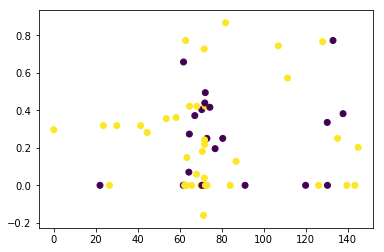

In [215]:
plot_data(X, y)

In [216]:
history, model = dense_cl_2f(X_train, y_train)
dic_dense_cl_2f = eva_dense_cl_2f(model, X_test, y_test)

#### (e) LSTM 2 Features

In [217]:
history, model = lstm_cl_2f(X_train, y_train)
dic_lstm_cl_2f = eva_lstm_cl_2f(model, X_test, y_test)

#### (f) Logistic Regression, SVC, Decision Tree Classifier, Random Forest Classifier, XGB Classifier

In [218]:
sklearn_cl_models_2f = sklearn_cl_models(X_train, y_train, X_test, y_test)

[23:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [219]:
sklearn_cl_models_cross_validation_2f = sklearn_cl_models_cross_validation(X, y)

[23:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [220]:
svc_optimizer_2f = svc_optimizer(X_train, y_train, X_test, y_test)

### (g) Scores between 1 Feature and 2 Features

In [221]:
score = score_df(dic_dense_cl_1f,
                 dic_lstm_cl_1f,
                 sklearn_cl_models_1f,
                 sklearn_cl_models_cross_validation_1f,
                 svc_optimizer_1f,
                 dic_dense_cl_2f,
                 dic_lstm_cl_2f,
                 sklearn_cl_models_2f,
                 sklearn_cl_models_cross_validation_2f,
                 svc_optimizer_2f
                )

score

,1 Feature,2 Features,sentiment_impact
DecisionTreeClassifier,0.384615,0.384615,0.000000
DecisionTreeClassifier (Cross Validation),0.488462,0.365385,-0.123077
Dense,0.615385,0.615385,0.000000
LSTM,0.615385,0.615385,0.000000
LogisticRegression,0.615385,0.615385,0.000000
LogisticRegression (Cross Validation),0.606410,0.606410,0.000000
RandomForestClassifier,0.384615,0.461538,0.076923
RandomForestClassifier (Cross Validation),0.488462,0.315385,-0.173077
SVC,0.615385,0.615385,0.000000
SVC (Cross Validation),0.639744,0.639744,0.000000
